In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({ 'font.size': 14 })
import os
from cycler import cycler

cm = ['#377eb8', '#ff7f00', '#4daf4a', '#999999', '#e41a1c', '#a65628', '#984ea3',
                  '#f781bf', '#dede00','#000000']
plt.rc('axes', prop_cycle = cycler('color', cm))
viridis = plt.cm.get_cmap('viridis', 7)(np.linspace(0, 1, 7))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

1.00    552.267881
1.06    149.274259
1.08    150.084511
dtype: float64
1.00    117.499961
1.06    126.840394
1.08    160.473593
dtype: float64
1.00     565.123714
1.06    1111.271522
1.08    2142.771420
dtype: float64


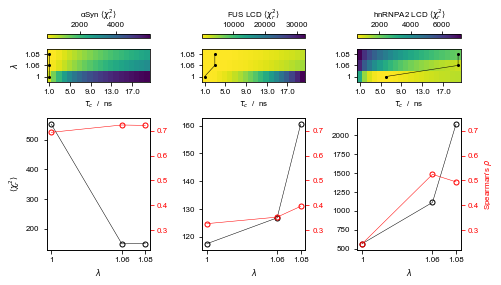

In [2]:
fig = plt.figure(figsize=(7,4))

ax1 = plt.subplot2grid( (6,3), (0,0), rowspan=2, colspan=1 )
ax2 = plt.subplot2grid( (6,3), (2,0), rowspan=4, colspan=1 )
ax3 = plt.subplot2grid( (6,3), (0,1), rowspan=2, colspan=1 )
ax4 = plt.subplot2grid( (6,3), (2,1), rowspan=4, colspan=1 )
ax5 = plt.subplot2grid( (6,3), (0,2), rowspan=2, colspan=1 )
ax6 = plt.subplot2grid( (6,3), (2,2), rowspan=4, colspan=1 )

up = [ax1,ax3,ax5]
down = [ax2,ax4,ax6]

for i,(name,labelname) in enumerate(zip(['aSyn','FUS','A2'],
                                  ['αSyn','FUS LCD','hnRNPA2 LCD'])):
    prot = pd.read_pickle(
        '../PRE_NMR/intrachain/chi2_{:s}_tc.pkl'.format(name)).astype(float).T
    prot_rho = pd.read_pickle(
        '../PRE_NMR/intrachain/rs_{:s}_tc.pkl'.format(name)).astype(float).T
    im = up[i].pcolor(prot,cmap=plt.cm.viridis_r)
    divider = make_axes_locatable(up[i])
    cax = divider.new_vertical(size="10%", pad=.15)
    fig.add_axes(cax)
    plt.colorbar(im, cax=cax, orientation="horizontal", 
                 label=r'{:s} $\langle \chi^2_r \rangle$'.format(labelname))
    cax.xaxis.set_ticks_position('top')
    cax.xaxis.set_label_position('top')
    
    up[i].plot(prot.T.idxmin()-.5,np.arange(.5,prot.shape[0],1),'ko-',ms=2,lw=.5)
    up[i].set_xticks(np.arange(.5,prot.shape[1],4))
    up[i].set_xticklabels(prot.columns[::4])
    up[i].set_yticks(np.arange(.5,prot.shape[0],1))
    up[i].set_yticklabels(['{:g}'.format(l) for l in prot.index])
    
    up[i].set_xlabel(r'$\tau_c$  /  ns')
    
    down[i].plot(prot.index,prot.T.min(),'ko-',mfc='None',ms=5,lw=.5,label=name)
    print(prot.T.min())
    
    rho_at_chi2min = [prot_rho.loc[l,prot.T.idxmin().loc[l]] for l in prot_rho.index]
    
    axtwin = down[i].twinx()
    axtwin.plot(prot_rho.index,rho_at_chi2min,'ro-',mfc='None',ms=5,lw=.5,label=name)
    axtwin.yaxis.set_ticks_position('right')
    axtwin.tick_params(axis='y', colors='r')
    axtwin.set_ylim(.22,.75)

    down[i].set_xticks(prot.index)
    down[i].set_xticklabels(['{:g}'.format(l) for l in prot.index])
    down[i].set_xlabel(r'$\lambda$')
    
up[0].set_ylabel(r'$\lambda$')    

down[0].set_ylabel(r'$\langle \chi^2_r \rangle$')
axtwin.set_ylabel(r"Spearman's $\rho$",color='r')
axtwin.yaxis.set_label_position("right")

plt.tight_layout()
plt.savefig('../intraPRE.pdf')

In [3]:
def plotPREdata(name,prot,obs,c,legend):
    calcPREs = prot.calcPREs
    expPREs = prot.expPREs
    labels = prot.calcPREs.columns
    cols = 1 if len(labels)<6 else 2
    rows = int(len(labels) / cols)
    if obs == 1:
        ylabel = '$I_{para}$  /  $I_{dia}$' 
    else:
        ylabel = '$\Gamma_2$  /  Hz' 
    chi2 = 0
    for ax,label in zip(axes.flatten(),labels):
        ax.errorbar(expPREs.index,expPREs.value[label],expPREs.error[label], 
            color='k', lw=0, marker='o', ms=1, elinewidth=.5, capsize=1, capthick=.5)    
        ax.plot(calcPREs[label].index,calcPREs[label].values,color=c,
                lw=0.5,marker='o',ms=1,label=legend)
        mask = np.isfinite(calcPREs[label])&np.isfinite(expPREs.value[label].values)
        chi = (expPREs.value[label].values[mask] - calcPREs[label][mask]) \
        / expPREs.error[label].values[mask]
        chi2 += np.nansum( np.power( chi, 2) ) / chi.size 
        if obs == 2:
            ax.set_yscale('log')
        ax.set_xticks(calcPREs.index[9::10])
        if calcPREs.index.size>200:
            ax.set_xticks(calcPREs.index[9::30])
        if calcPREs.index.size>400:
            ax.set_xticks(calcPREs.index[9::60])
        ax.set_ylabel(ylabel)
    if cols == 2:
        axes.flatten()[-2].set_xlabel('Residue #')
        for i in np.arange(len(labels))[1::2]:
            axes.flatten()[i].yaxis.set_label_position("right")
            axes.flatten()[i].yaxis.set_ticks_position('right')
    print(legend,chi2/len(labels))
    axes.flatten()[-1].set_xlabel('Residue #')
    plt.tight_layout(w_pad=0.5)

1 552.2678806586229
1.06 149.27425944345472
1.08 150.08451126711302


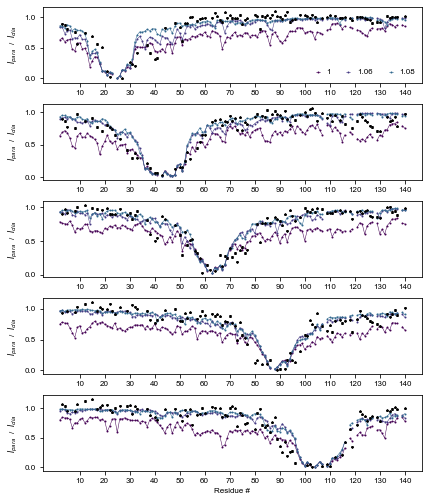

In [4]:
name = 'aSyn'  

prot = pd.read_pickle('../PRE_NMR/intrachain/'+name+'_PREs.pkl')
figsize = (6,4)
labels = prot[1.00].calcPREs.columns
cols = 1 if len(labels)<6 else 2
rows = int(len(labels) / cols)
if len(labels)>6 or len(labels)==5:
    figsize = (6,7)
fig, axes = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=figsize)
for l,c in zip(prot.columns,viridis):
    pre = prot[l]
    plotPREdata(name,pre,1,c,legend='{:g}'.format(l))
plt.tight_layout()
axes[0].legend(frameon=False,ncol=4,handlelength=.5)
plt.show()

1 117.49996141853912
1.06 126.84039416087921
1.08 160.473592851972


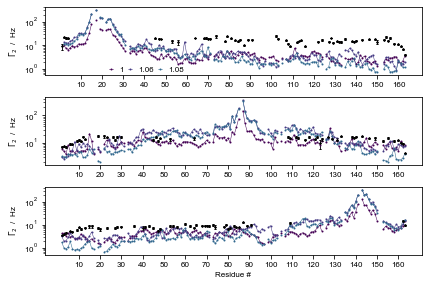

In [5]:
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

name = 'FUS'    
    
prot = pd.read_pickle('../PRE_NMR/intrachain/'+name+'_PREs.pkl')
figsize = (6,4)
labels = prot[1.00].calcPREs.columns
cols = 1 if len(labels)<6 else 2
rows = int(len(labels) / cols)
if len(labels)>6 or len(labels)==5:
    figsize = (6,7)
fig, axes = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=figsize)
for l,c in zip(prot.columns,viridis):
    pre = prot[l]
    plotPREdata(name,pre,2,c,legend='{:g}'.format(l))
plt.tight_layout()
axes[0].legend(frameon=False,ncol=3,handlelength=.5,labelspacing=0,
                  columnspacing=.5,borderpad=0,loc=(.17,.03))
plt.show()

1 565.1237141089172
1.06 1111.2715223427308
1.08 2142.7714201596013


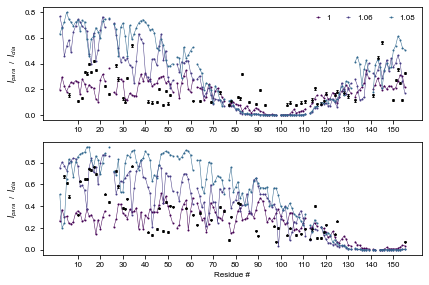

In [6]:
name = 'A2'  

prot = pd.read_pickle('../PRE_NMR/intrachain/'+name+'_PREs.pkl')
figsize = (6,4)
labels = prot[1.00].calcPREs.columns
cols = 1 if len(labels)<6 else 2
rows = int(len(labels) / cols)
if len(labels)>6 or len(labels)==5:
    figsize = (6,7)
fig, axes = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=figsize)
for l,c in zip(prot.columns,viridis):
    pre = prot[l]
    plotPREdata(name,pre,1,c,legend='{:g}'.format(l))
plt.tight_layout()
axes[0].legend(frameon=False,ncol=4,handlelength=.5)
plt.show()